# Learning 1d Pure Advection in Conservative Form

To verify that our PINN implementation is working well, we test the PINN on the following problem:
$$
    \begin{cases}
        u_t + au_x = 0\\
        \lim_{|x|\rightarrow\infty}u(t, x) = 0\\
        u(0, x) = u_0(x)
    \end{cases}
$$ where $u_0 = \mathcal{N}(x|0, 1)$. 

In this case, the NN solution is assumed to have the following model (conservative advection):
$$
    \frac{\partial u_{\theta_1}}{\partial t} + \frac{\partial}{\partial x}\bigg(\mathcal{V}_{\theta_2}(x)u_{\theta_1}\bigg) = 0
$$

The data is generated in `constant_advection.ipynb`.

In this test case, the true advection velocity is a spatially varying function.

* In this example, we take the analytical solution considered in: https://www.researchgate.net/publication/235711961_Analytical_Solutions_for_Advection_and_Advection-Diffusion_Equations_with_Spatially_Variable_Coefficients

The subsequent paper may also be of future interest: https://www.sciencedirect.com/science/article/pii/S0307904X99000050

In [2]:
from PINN.AdvectionNet import *
# Testing
import matplotlib.pyplot as plt
import torch
import numpy as np
import scipy

# set random seeds
np.random.seed(10)
torch.manual_seed(10);

import numpy as np    
import matplotlib.pyplot as plt

The analytic solutio is given by (quasi-Gaussian profile case):
$$
    u(t, x) = \frac{M_0}{x\sigma\sqrt{2\pi}}\exp\bigg(
        -\frac{[\ln (x/x_0) - u_0t]^2}{2\sigma^2}
    \bigg)
$$ where $M_0$ is the mass that is conserved. The above expression satisfies the conservative advection:
$$
    \frac{\partial u}{\partial t} + \frac{\partial}{\partial x}\bigg(
        v(x)u
    \bigg) = 0
$$ where $v(x) = u_0x$. $x\in (0, \infty)$ with vanishing boundary condition. 

In [3]:
# define computational grids
xmin, xmax = 0.05, 4.0
nx = 2000
xgrid = np.linspace(xmin, xmax, nx)
dx = xgrid[1]-xgrid[0]

dt = 0.01
tmax = 20.0
tgrid = np.arange(0, tmax, dt)
nt = len(tgrid)

# compute solution
M0 = 1.0
u0 = 0.1
sigma = 0.2
c0 = 10.0
x0 = 0.2
u_sol = np.zeros([nt, nx])
for i in range(nt):
    t = tgrid[i]
    u_sol[i, :] = ( M0/(xgrid*sigma*np.sqrt(2*np.pi)) ) * np.exp(-((np.log(xgrid / x0)-u0*t)**2/(2*(sigma**2))))

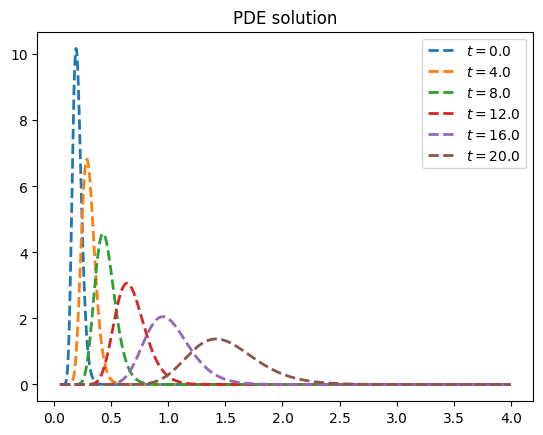

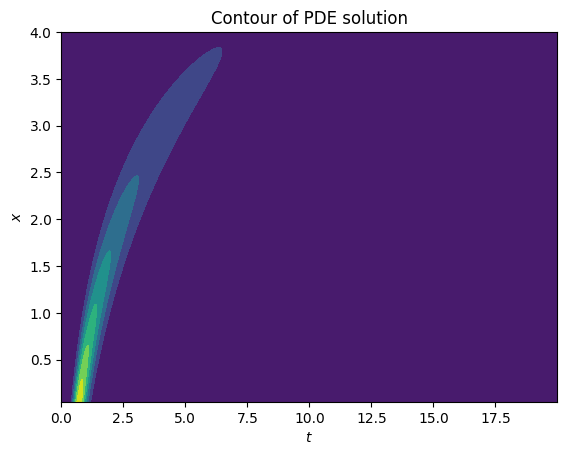

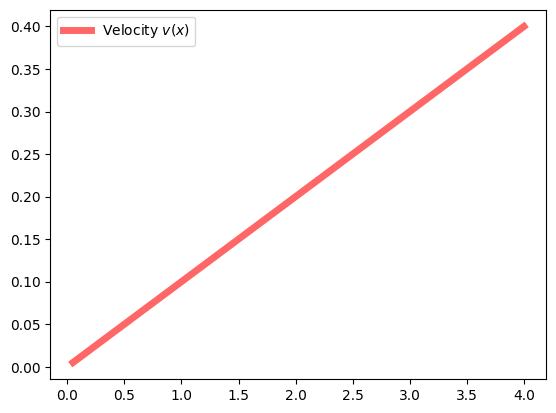

In [4]:
plt.figure(1);
for i in range(nt):
    if i % 400 == 0:
        plt.plot(xgrid, u_sol[i, :], "--", lw=2.0, label=r"$t = {}$".format(i*dt));
plt.plot(xgrid, u_sol[-1, :], "--", lw=2.0, label=r"$t = {}$".format(nt*dt));
plt.title("PDE solution");
plt.legend();

plt.figure(2);
plt.contourf(tgrid, xgrid, u_sol);
plt.ylabel(r"$x$"); plt.xlabel(r"$t$");
plt.title("Contour of PDE solution");

plt.figure(3);
plt.plot(xgrid, u0*xgrid, lw=5.0, label=r"Velocity $v(x)$", color="red", alpha=0.6);
plt.legend();

In [5]:
# save data for PINN training
scipy.io.savemat("../data/LinearOscillator/Variable_Advection_Conservative.mat", {
    "xgrid": xgrid.reshape(1, -1),
    "tgrid": tgrid.reshape(1, -1),
    "pmc": u_sol
})

# save a smaller dataset
subsample_t = 4
subsample_x = 2
xgrid_small = xgrid.reshape(1, -1)[:, 0:-1:subsample_x].squeeze(),
tgrid_small = tgrid.reshape(1, -1)[:, 0:-1:subsample_t].squeeze()
u_sol_small = u_sol[0:-1:subsample_t, 0:-1:subsample_x]
scipy.io.savemat("../data/LinearOscillator/Variable_Advection_Conservative_small.mat", {
    "xgrid": xgrid_small,
    "tgrid": tgrid_small,
    "pmc": u_sol_small
})
print("Training data size = {}\n".format(u_sol_small.shape))

Training data size = (500, 1000)



In [ ]:
# PINN experiments
# subsampled spatial training data
data_path = "../data/LinearOscillator/Variable_Advection_Conservative_small.mat"
# create PINN
pinn = AdvectionNet(indim=2, outdim=1, data_path=data_path, scheduler="ExponentialLR")
# testing training
info = train(
    pinn, pinn.optimizer, pinn.scheduler, batch_size=2**8,
    epochs=200, batch_print=200, mode="all", conservative_pde=True
)

------------------------------------------------------------

=> Data Loaded at: ../data/LinearOscillator/Variable_Advection_Conservative_small.mat 

----> Total Number of observations = 498002 

------------------------------------------------------------

------------------------------------------------------------------

|                      Epoch 1                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

| => | Batch 1001 |

| => | Batch 1201 |

| => | Batch 1401 |

| => | Batch 1601 |

| => | Batch 1801 |

---------- 

++ Learning rate reduced, now at = 0.000098
Batch PDE Loss = 0.0013704415879116309 

Batch Data Loss = 0.4175574199267 

------------------------------------------------------------------

|                      Epoch 2                                  |

------------------------------------------------------------------


| => | Batch 1401 |

| => | Batch 1601 |

| => | Batch 1801 |

---------- 

++ Learning rate reduced, now at = 0.000085
Batch PDE Loss = 0.00737968927899805 

Batch Data Loss = 0.005804739258059711 

------------------------------------------------------------------

|                      Epoch 16                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

| => | Batch 1001 |

| => | Batch 1201 |

| => | Batch 1401 |

| => | Batch 1601 |

| => | Batch 1801 |

---------- 

++ Learning rate reduced, now at = 0.000084
Batch PDE Loss = 0.0072239581493706235 

Batch Data Loss = 0.005847998791088494 

------------------------------------------------------------------

|                      Epoch 17                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch

| => | Batch 1601 |

| => | Batch 1801 |

---------- 

++ Learning rate reduced, now at = 0.000073
Batch PDE Loss = 0.007079709685649103 

Batch Data Loss = 0.0039025574987691432 

------------------------------------------------------------------

|                      Epoch 31                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

| => | Batch 1001 |

| => | Batch 1201 |

| => | Batch 1401 |

| => | Batch 1601 |

| => | Batch 1801 |

---------- 

++ Learning rate reduced, now at = 0.000072
Batch PDE Loss = 0.0070738817135795945 

Batch Data Loss = 0.003727157440383234 

------------------------------------------------------------------

|                      Epoch 32                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batc

| => | Batch 1801 |

---------- 

++ Learning rate reduced, now at = 0.000063
Batch PDE Loss = 0.006472149091587373 

Batch Data Loss = 0.002983697088067436 

------------------------------------------------------------------

|                      Epoch 46                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

| => | Batch 1001 |

| => | Batch 1201 |

| => | Batch 1401 |

| => | Batch 1601 |

| => | Batch 1801 |

---------- 

++ Learning rate reduced, now at = 0.000062
Batch PDE Loss = 0.006411866297330293 

Batch Data Loss = 0.0029440008985332365 

------------------------------------------------------------------

|                      Epoch 47                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 

---------- 

++ Learning rate reduced, now at = 0.000054
Batch PDE Loss = 0.00625643709886048 

Batch Data Loss = 0.0025917395270329715 

------------------------------------------------------------------

|                      Epoch 61                                  |

------------------------------------------------------------------

| => | Batch 1 |

| => | Batch 201 |

| => | Batch 401 |

| => | Batch 601 |

| => | Batch 801 |

| => | Batch 1001 |



In [7]:
# visualize losses
plt.figure(1, figsize=(16, 8));
plt.plot(np.log10(info["pde_loss"]), lw=2, color="red");
plt.title("PDE Loss vs. Epoch");

plt.figure(2, figsize=(16, 8));
plt.plot(np.log10(info["data_loss"]), lw=2, color="blue");
plt.title("Data Loss vs. Epoch");

# plt.figure(3, figsize=(16, 8));
# plt.plot(np.log10(info["reg_loss"]), lw=2, color="purple");
# plt.title("Regularity Loss vs. Epoch");
query = cartesian_data(pinn.tgrid, pinn.xgrid)

# D_pred = pinn.D_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
# G_pred = pinn.G_nn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()
p_pred = pinn(query).reshape(pinn.nx, pinn.nt).T.detach().numpy()

# grids
tgrid = pinn.tgrid.detach().numpy()
xgrid = pinn.xgrid.detach().numpy()

p_exact = pinn.raw_data["pmc"]
dx = pinn.dx.item()
dt = pinn.dt.item()

# plt.figure(1);
# plt.contourf(xgrid, tgrid, G_pred);
# plt.colorbar();

# plt.figure(2);
# plt.plot(xgrid, G_pred[0:-1:10, :].T, alpha=0.4, lw=1.5);
# plt.plot(xgrid, 1.1*np.ones_like(xgrid), "--", lw=4.5, color="red", alpha=0.8, label="exact");
# plt.legend();

NameError: name 'info' is not defined

<Figure size 1600x800 with 0 Axes>

In [8]:
inputs = cartesian_data(pinn.tgrid, pinn.xgrid)
G_pred = pinn.G_nn(inputs[:, 1][:, None]).reshape(pinn.nx, pinn.nt).T.detach().numpy()
p_pred = pinn(inputs).reshape(pinn.nx, pinn.nt).T.detach().numpy()

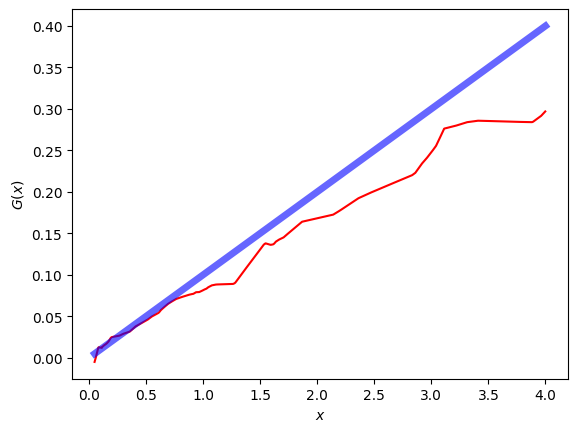

In [9]:
plt.figure(1);
plt.plot(pinn.xgrid.detach().numpy(), G_pred[0, :], color="red");
plt.plot(xgrid, u0*xgrid, lw=5.0, label=r"Velocity $v(x)$", color="blue", alpha=0.6);
plt.xlabel(r"$x$");
plt.ylabel(r"$G(x)$");

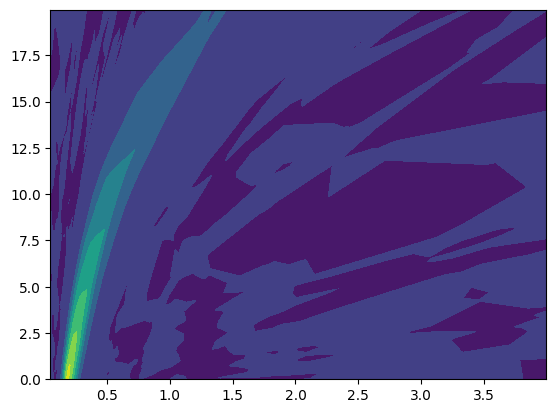

In [10]:
# interpolation
plt.contourf(pinn.xgrid.detach().numpy(), pinn.tgrid.detach().numpy(), p_pred);

In [11]:
dx = dx.item()

In [12]:
plt.figure(2);
# relative error in L^2 from KDE benchmark
l2_rel_err = np.sum(((p_pred-p_exact)**2)*dx, 1) / np.sum((p_exact**2)*dx, 1)
tgrid = pinn.tgrid.detach().numpy()
plt.plot(tgrid, l2_rel_err, color="red", lw=1.5);
plt.grid(True);
plt.title(r"Relative error in $L^2$");
plt.xlabel(r"$t$"); 
plt.ylabel(r"$L^2(\mathbb{R})$ error");

NameError: name 'p_exact' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
model_path = "./PINN/models/linear_advection_conservative_epoch_200"
torch.save(pinn.state_dict(), model_path)